# Final version of Titanic project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import time

from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Intro

**Aims:**
I'm trying to predict the survival outcomes of the passengers on the Titanic using machine learning techniques.

**Feature Engineering Choices:**
I did some exploratory data analysis and visualisation (see [my very messy Jupyter notebook from Monday](Titanic_Exploratory_Data_Analysis.ipynb)), and have made a few decisions:
- *Passenger class:* Highly correlated with survival outcome. Since this is a categorical value, I'm using one-hot encoding to represent this variable.
- *Imputing age:* There are missing values for the passengers' age. I'm imputing them by using the median age. This is more robust to outlier distortion.
- *Age*: I'm scaling age so that any accidental differences in range between the training and test data do not bias the model.
- *SibSp and Parch:* These indicate how many siblings or spouses a passenger is travelling with (i.e. people roughly your age) and how many parents or children (i.e. people either much older or much younger). Neither seem to be strongly correlated with survival, but I will combine them into a "GroupSize" metric that hopefully will magnify whatever predictive power either of them has. Again, I will scale this.
- *Embark:* Indicates where a passenger embarked. There are different distributions especially in passenger class depending on where someone got on the *Titanic* -- e.g. many first-class passengers got on at Cherbourg. I'm going to use one-hot encoding here. There is one missing value. Since SimpleImputer() doesn't work for categorical values [see here] (https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/), I'm going to replace this by a value of 'M' for missing data point.
- *Sex* appears to have had quite a strong effect on survival outcome. I'm using one-hot encoding for this.
- *Name, Ticket, Cabin:* It is possible to get information out of these columns, as indicated [here] (https://www.kaggle.com/viczyf/titanic-random-forest-82-78), but that would require a lot of engineering. I'm not going to focus on these columns and will therefore remove them from the data under consideration.
- *Fare:* Odd distribution that doesn't really align well with passenger class (there are first-class passengers whose fare was around the same as third-class passengers). I will leave this in as a scaled value but am not sure it will really help the model.

**Model Choice:**
I'm going to compare a logistic regression model (good for binary outcomes) and a random forest model.

**Model Evaluation:**
The evaluation metric we're using for this project is pre-defined (by the terms of the Kaggle competition) as accuracy.

**Cross-Validation:**
I'm using bootstrapping to cross-validate.

## Import data and split

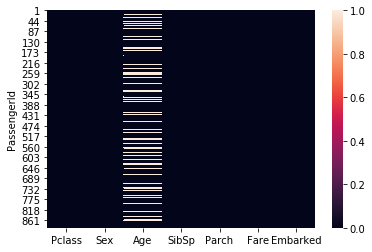

In [2]:
### IMPORT DATA
df = pd.read_csv('train.csv', index_col = 0)

df = df.drop(['Cabin', 'Ticket', 'Name'], axis = 1)

y = df['Survived']

# just to be sure -- dropping survival column from df
df = df.drop(['Survived'], axis = 1)

sns.heatmap(df.isna())

In [3]:
### CREATE NEW GROUPSIZE COLUMN

df['GroupSize'] = df['SibSp'] + df['Parch']

df = df.drop(['SibSp', 'Parch'], axis = 1)

In [4]:
### EMBARK COLUMN

## Turns out it is a huge pain to use factorize() here as it outputs an array, which then needs transformation to be inserted back into the df.
## I am going to manually replace values.


# df['Embarked'] = df['Embarked'].fillna(np.nan, 'M')

df['Embarked'] = df['Embarked'].fillna('M')

In [5]:
### For pipeline below, passenger class must be formatted as string

df['Pclass'] = df['Pclass'].astype(str)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     891 non-null    object 
 1   Sex        891 non-null    object 
 2   Age        714 non-null    float64
 3   Fare       891 non-null    float64
 4   Embarked   891 non-null    object 
 5   GroupSize  891 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 48.7+ KB


In [7]:
### SPLIT DATA INTO TRAIN AND TEST SETS
Xtrain, Xtest, ytrain, ytest = train_test_split(df, y)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((668, 6), (223, 6), (668,), (223,))

In [8]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 538 to 25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     668 non-null    object 
 1   Sex        668 non-null    object 
 2   Age        531 non-null    float64
 3   Fare       668 non-null    float64
 4   Embarked   668 non-null    object 
 5   GroupSize  668 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 36.5+ KB


## Build and evaluate a baseline model

(From Monday afternoon challenges)

In [7]:
# take out all of the columns we can't immediately use because they're in the wrong format, have too many NaNs, etc.

dummy_cols = ['Pclass', 'Age', 'SibSp', 'Fare']

X_dummy_train = X_train[dummy_cols]
X_dummy_test = X_test[dummy_cols]

In [8]:
m_base = DummyClassifier(strategy='most_frequent')
m_base.fit(X_dummy_train, y_train)
y_pred_base = m_base.predict(X_dummy_train)

In [9]:
f'Training accuracy: {m_base.score(X_dummy_train, y_train)}'

'Training accuracy: 0.6107784431137725'

In [10]:
f'Test accuracy: {m_base.score(X_dummy_test, y_test)}'

'Test accuracy: 0.6322869955156951'

**Dummy model before any kind of feature engineering has a test accuracy of 63%.**

If our dummy model predicted "do not survive" for every passenger, it would have an accuracy of around 60% (around 60% of passengers died in the shipwreck).

If the dummy model is flipping a coin, it should do worse than this (and this is borne out above).

**Interesting note for later:** The dummy model has a higher accuracy on the test than the training

## Feature Engineering

### Dealing with missing values

I initially hoped to use `impute.SimpleImputer` to do impute missing ages and points of embarkation within my transformer below. For Embark, we will need to first factorise into 3 categories. I did this above before splitting into training and test data. Since I ended up having a lot of trouble getting `impute.SimpleImputer` to work, for the purposes of this project (and meeting the Friday deadline!) I ended up doing this manually after all.

### New variable: GroupSize

I created this before splitting the data. Perhaps not the best practice, but only values from within each row interact, meaning that each row remains independent of other rows (and we maintain separation of the test and training data). This is a lot simpler than implementing it within the transformer. :)

### Create Transformer

To Do list for transformer, in order:

- Impute missing ages using median
- Impute missing Embark values using median
- One-hot encode Pclass, Sex, Embark
- Pass through Fare, Age, GroupSize (will be scaled later)

Note: Because we are doing different kinds of feature encoding, sometimes on the same columns, we need to define separate `pipeline` steps. This is because `ColumnTransformer()` itself runs on the original column each line, rather than the output of a previous line, meaning that you can't run it on the same column.

**[EDIT]** I've removed from this notebook a lot of different things that I treid to do and couldn't get to work... we are picking up after my decision not to include imputing missing values in the preprocessing pipeline.

## Ultimate decision on imputating missing ages

Let's do this manually.

In [9]:
# Find median age in Xtrain

median_age = Xtrain['Age'].median()
median_age

28.0

In [10]:
# Replace missing values with median in training and test data

Xtrain['Age'] = Xtrain['Age'].fillna(median_age)
Xtest['Age'] = Xtest['Age'].fillna(median_age)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Build pipeline

In [11]:
Xtrain.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'GroupSize'], dtype='object')

In [75]:
trans = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), ['Pclass', 'Sex', 'Embarked']), # cols to one-hot-encode
#    ('binning', KBinsDiscretizer(n_bins = 3, encode = 'onehot', strategy = 'quantile'), ['GroupSize', 'Fare']), 
    ('do_nothing', 'passthrough', ['Age'])   # columns to ignore
])

In [73]:
# Pipeline that transforms, then scales, then feeds into LogReg

preprocessor = make_pipeline(
    trans,                 # transformed data
    MinMaxScaler()        # scale
)

preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('binning',
                                                  KBinsDiscretizer(n_bins=3),
                                                  ['GroupSize', 'Fare']),
                                                 ('do_nothing', 'passthrough',
                                                  ['Age'])])),
                ('minmaxscaler', MinMaxScaler())])

#### Preprocess training and test data

In [74]:
# Preprocess the Xtrain data
Xtrain_preprocessed = preprocessor.fit_transform(Xtrain)
print(Xtrain_preprocessed.shape)

# Preprocess Xtest data
Xtest_preprocessed = preprocessor.transform(Xtest)
Xtest_preprocessed.shape

(668, 15)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


(223, 15)

#### Fit model

In [15]:
m = LogisticRegression()

# fit log reg model to preprocessed data
m.fit(Xtrain_preprocessed, ytrain)
m.score(Xtrain_preprocessed, ytrain)

0.8008982035928144

### Optimisation

#### Step 1: Randomized search to select hyperparameters

Sources: https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search/; 
https://chrisalbon.com/machine_learning/model_selection/pipelines_with_parameter_optimization/

In [16]:
# define hyperparameters: we will learn next week what these actually are
hyperparameters = {
    'C' : np.logspace(-4, 10, 50),
}

hyperparameters

{'C': array([1.00000000e-04, 1.93069773e-04, 3.72759372e-04, 7.19685673e-04,
        1.38949549e-03, 2.68269580e-03, 5.17947468e-03, 1.00000000e-02,
        1.93069773e-02, 3.72759372e-02, 7.19685673e-02, 1.38949549e-01,
        2.68269580e-01, 5.17947468e-01, 1.00000000e+00, 1.93069773e+00,
        3.72759372e+00, 7.19685673e+00, 1.38949549e+01, 2.68269580e+01,
        5.17947468e+01, 1.00000000e+02, 1.93069773e+02, 3.72759372e+02,
        7.19685673e+02, 1.38949549e+03, 2.68269580e+03, 5.17947468e+03,
        1.00000000e+04, 1.93069773e+04, 3.72759372e+04, 7.19685673e+04,
        1.38949549e+05, 2.68269580e+05, 5.17947468e+05, 1.00000000e+06,
        1.93069773e+06, 3.72759372e+06, 7.19685673e+06, 1.38949549e+07,
        2.68269580e+07, 5.17947468e+07, 1.00000000e+08, 1.93069773e+08,
        3.72759372e+08, 7.19685673e+08, 1.38949549e+09, 2.68269580e+09,
        5.17947468e+09, 1.00000000e+10])}

In [17]:
# define the grid search: which model to use (the one we defined above) and which hyperparameters
clf = RandomizedSearchCV(m, hyperparameters)

# 
clf.fit(Xtrain_preprocessed, ytrain)

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': array([1.00000000e-04, 1.93069773e-04, 3.72759372e-04, 7.19685673e-04,
       1.38949549e-03, 2.68269580e-03, 5.17947468e-03, 1.00000000e-02,
       1.93069773e-02, 3.72759372e-02, 7.19685673e-02, 1.38949549e-01,
       2.68269580e-01, 5.17947468e-01, 1.00000000e+00, 1.93069773e+00,
       3.72759372e+00, 7.19685673e+0...
       7.19685673e+02, 1.38949549e+03, 2.68269580e+03, 5.17947468e+03,
       1.00000000e+04, 1.93069773e+04, 3.72759372e+04, 7.19685673e+04,
       1.38949549e+05, 2.68269580e+05, 5.17947468e+05, 1.00000000e+06,
       1.93069773e+06, 3.72759372e+06, 7.19685673e+06, 1.38949549e+07,
       2.68269580e+07, 5.17947468e+07, 1.00000000e+08, 1.93069773e+08,
       3.72759372e+08, 7.19685673e+08, 1.38949549e+09, 2.68269580e+09,
       5.17947468e+09, 1.00000000e+10])})

In [23]:
# run the best model on the preprocessed TRAINING data
print(clf.best_estimator_.score(Xtrain_preprocessed, ytrain))

# run the best model on the preprocessed TEST data; store in variable
test_score = clf.best_estimator_.score(Xtest_preprocessed, ytest)
print(clf.best_estimator_.score(Xtest_preprocessed, ytest))



0.7874251497005988
0.8116591928251121


### Bootstrapping accuracy with confidence interval

In [36]:
boots_train = []

for i in range(1000):
    Xb, yb = resample(Xtrain_preprocessed, ytrain)
    clf.best_estimator_.fit(Xb, yb)
    score = clf.best_estimator_.score(Xb, yb)
    boots_train.append(score)
    
    
boots_test = []

for i in range(1000):
    Xb, yb = resample(Xtest_preprocessed, ytest)
    clf.best_estimator_.fit(Xb, yb)
    score = clf.best_estimator_.score(Xb, yb)
    boots_test.append(score)

In [ ]:
# Sort bootstrapping outcomes
boots_train.sort()
boots_test.sort()

In [92]:
ci95_train = boots_train[25:-25]
ci95_test = boots_test[25:-25]

(0.72, 0.9)

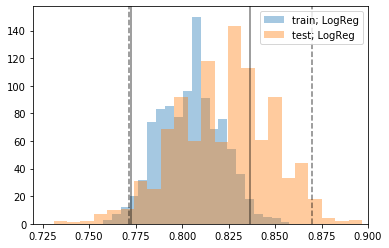

In [67]:
# Plotting

sns.distplot(boots_train,  kde=False, label = 'train; LogReg')
plt.axvline(ci95_train[0], color = 'black', alpha = 0.5)
plt.axvline(ci95_train[-1], color = 'black', alpha = 0.5)

sns.distplot(boots_test,  kde=False, label = 'test; LogReg')
plt.axvline(ci95_test[0], color = 'black', linestyle = '--', alpha = 0.5)
plt.axvline(ci95_test[-1] , color = 'black', linestyle = '--', alpha = 0.5)

plt.legend()
plt.xlim(.72, .9)

## Random Forest Model

I'm going to use the data I've already preprocessed, so that I can compare the outcomes better between the LogReg and Random Forest models.

In [54]:
# Set up model

rf = RandomForestClassifier()

### Parameter optimization using randomized search

In [93]:
import time

In [98]:
# Dictionary of hyperparameters

hyperparams = {
    'max_depth' : list(range(1, 11)),
    'min_samples_split' : list(range(2, 20, 5))
}

# create an estimator
g = GridSearchCV(rf, hyperparams, cv = 5)

In [100]:
start = time.time()
# now fit it on your data
g.fit(Xtrain_preprocessed, ytrain)

stop = time.time()

print(f'Runtime for training RandomForestClassifier was:      {stop - start}s')

Runtime for training RandomForestClassifier was:      29.73627781867981s


In [84]:
g.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_split=12)

### Bootstrapping

In [85]:
rf_boots_train = []

for i in range(100):
    Xb, yb = resample(Xtrain_preprocessed, ytrain)
    g.best_estimator_.fit(Xb, yb)
    score = g.best_estimator_.score(Xb, yb)
    rf_boots_train.append(score)
    
    
rf_boots_test = []

for i in range(100):
    Xb, yb = resample(Xtest_preprocessed, ytest)
    g.best_estimator_.fit(Xb, yb)
    score = g.best_estimator_.score(Xb, yb)
    rf_boots_test.append(score)

In [86]:
# Sort bootstrapping outcomes
rf_boots_train.sort()
rf_boots_test.sort()

In [87]:
rf_ci90_train = rf_boots_train[5:-5]
rf_ci90_test = rf_boots_test[5:-5]

(0.8, 0.95)

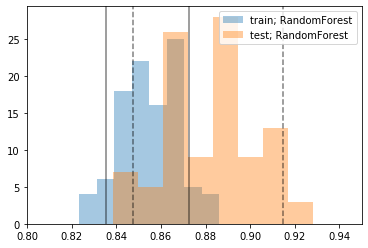

In [91]:
# Plotting

sns.distplot(rf_boots_train,  kde=False, label = 'train; RandomForest')
plt.axvline(rf_ci90_train[0], color = 'black', alpha = 0.5)
plt.axvline(rf_ci90_train[-1], color = 'black', alpha = 0.5)

sns.distplot(rf_boots_test,  kde=False, label = 'test; RandomForest')
plt.axvline(rf_ci90_test[0], color = 'black', linestyle = '--', alpha = 0.5)
plt.axvline(rf_ci90_test[-1] , color = 'black', linestyle = '--', alpha = 0.5)

plt.legend()
plt.xlim(.8, .95)